In [18]:
import numpy as np
import matplotlib.pyplot as plt
import math
from neural_network_tut import load_data

In [19]:
def load_dataset():
    X_train, Y_train, X_test, Y_test = load_data()

    X_train, X_test = X_train.T / 255, X_test.T / 255
    Y_train, Y_test = Y_train.reshape((1, Y_train.shape[0])), Y_test.reshape((1, Y_test.shape[0]))

    return X_train, Y_train, X_test, Y_test

In [150]:
def dict_to_array(params, weights):
    L = len(params) // 2
    arr = []
    flattened_params = {}
    flattened_shapes = {}
    weight, bias = weights
    
    if weight == 'dW':
        L = len(params) // 2 - 1
    
    for l in range(L):
        weight_flattened, bias_flattened = params[weight + str(l+1)].flatten(), params[bias + str(l+1)].flatten()
        if weight not in flattened_params or bias not in flattened_params:
            flattened_params[weight] = weight_flattened
            flattened_params[bias] = bias_flattened
        else:
            flattened_params[weight] = np.concatenate((flattened_params[weight], weight_flattened))
            flattened_params[bias] = np.concatenate((flattened_params[bias], bias_flattened))
            
        flattened_shapes[weight + str(l+1)] = weight_flattened.shape[0]
        flattened_shapes[bias + str(l+1)] = bias_flattened.shape[0]
        
    arr = np.concatenate((flattened_params[weight], flattened_params[bias]))
    arr = arr.reshape((arr.shape[0], 1))
    
    return arr, (flattened_params, flattened_shapes)
        

In [131]:
def vector_to_dict(flattened_cache, layer_dims):
    parameters = {}
    flattened_params, flattened_shapes = flattened_cache
    L = len(flattened_shapes) // 2
    weight_n = sum([flattened_shapes["W" + str(l+1)] for l in range(L)])
    bias_n = sum([flattened_shapes["b" + str(l+1)] for l in range(L)])
    
    weights = flattened_params[:weight_n]
    bias = flattened_params[weight_n:]
    n_prev_w = 0
    n_prev_b = 0
    
    for l in range(L):
        parameters["W" + str(l+1)] = weights[n_prev_w:n_prev_w + flattened_shapes["W" + str(l+1)]].reshape((layer_dims[l+1], layer_dims[l]))
        parameters["b" + str(l+1)] = bias[n_prev_b:n_prev_b + flattened_shapes["b" + str(l+1)]].reshape((layer_dims[l+1], 1))
        n_prev_w, n_prev_b = flattened_shapes["W" + str(l+1)], flattened_shapes["b" + str(l+1)]
        
    return parameters
    

In [20]:
def one_hot_encoding(Y, num_labels):
    one_hot = np.zeros((num_labels, Y.shape[1]))

    for i, val in enumerate(Y[0]):
        one_hot[val, i] = 1.0

    return one_hot

In [21]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z)), z

In [22]:
def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    a, _ = sigmoid(Z)

    dZ = dA * (a * (1 - a))
    return dZ

In [181]:
def initialize_weights(layer_dims):
    L = len(layer_dims)
    parameters = {}

    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * np.sqrt(2 / (layer_dims[l] + layer_dims[l-1]))
        parameters["b" + str(l)] = np.zeros((layer_dims[l], 1))

    return parameters

In [24]:
def random_mini_batches(X, Y, mini_batch_size=64):
    m = X.shape[1]
    minibatches = []

    permutation = np.random.permutation(m)
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    num_complete_batches = math.floor(m / mini_batch_size)
    for k in range(num_complete_batches):
        mini_batch_X = shuffled_X[:, k*mini_batch_size:(k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size:(k + 1) * mini_batch_size]

        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * num_complete_batches:]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * num_complete_batches:]

        minibatch = (mini_batch_X, mini_batch_Y)
        minibatches.append(minibatch)

    return minibatches

In [25]:
def initialize_adam(parameters):
    L = len(parameters) // 2
    v = {}
    s = {}

    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l + 1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l + 1)] = np.zeros(parameters["b" + str(l+1)].shape)

    return v, s


In [26]:
def linear_forward_unit(A, W, b):
    Z = np.dot(W, A) + b
    linear_cache = (A, W, b)

    return Z, linear_cache

In [27]:
def linear_activation_unit(A_prev, W, b, activation):
    if activation == "sigmoid":
        Z, linear_cache = linear_forward_unit(A_prev, W, b)
        A, activation_cache = sigmoid(Z)

    caches = (linear_cache, activation_cache)
    return A, caches


In [28]:
def feed_forward_propagation(X, parameters):
    L = len(parameters) // 2
    m = X.shape[1]
    caches = []
    A = X

    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_unit(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], "sigmoid")
        caches.append(cache)

    AL, cache = linear_activation_unit(A, parameters["W" + str(L)], parameters["b" + str(L)], activation="sigmoid")
    caches.append(cache)

    return AL, caches

In [204]:
def compute_cost(AL, Y, parameters, lambd):
    m = AL.shape[1]
    L = len(parameters) // 2
    
    L2_regularization = 0
    
    for l in range(L):
        L2_regularization += lambd/(2*m) * np.sum(np.sum(np.square(parameters["W" + str(l+1)])))

    logpreds = Y * np.log(AL) # + (1 - Y) * np.log(AL)
    error = (-1/m) * np.sum(logpreds) + L2_regularization
    return error

In [30]:
def linear_backward_unit(dZ, linear_cache):
    A_prev, W, b = linear_cache
    m = A_prev.shape[1]

    dW = (-1/m) * np.dot(dZ, A_prev.T)
    db = (-1/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [31]:
def backward_activation_unit(dA, cache, activation):
    linear_cache, activation_cache = cache

    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_unit(dZ, linear_cache)

    return dA_prev, dW, db


In [180]:
def backward_propagation(AL, Y, caches, lambd):
    grads = {}
    L = len(caches)
    m = AL.shape[1]

    # Initialize backpropagation
    AL = np.clip(AL, 1e-100, 1)  # clip to avoid 0
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))

    # Calculate fro the Lth layer
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation_unit(dAL, current_cache, "sigmoid")

    # For layers l = L-2...0
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        _, W, _ = current_cache[0]
        dA_prev_temp, dW_temp, db_temp = backward_activation_unit(grads["dA" + str(l+1)], current_cache, "sigmoid")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l+1)] = dW_temp + lambd/m * W
        grads["db" + str(l+1)] = db_temp

    return grads

In [154]:
def gradient_checking(parameters, grads, X, Y, layer_dims, epsilon=1e-7):
    parameters_value, flattened_cache = dict_to_array(parameters, ("W", "b"))
    grad_values, _ = dict_to_array(grads, ("dW", "db"))
    num_parameters = parameters_value.shape[0]
    J_plus = np.zeros((num_parameters, 1))
    J_minus = np.zeros((num_parameters, 1))
    gradapprox = np.zeros((num_parameters, 1))
    
    for i in range(num_parameters):
        thetaplus = np.copy(parameters_value)
        thetaplus[i][0] += epsilon
        AL, _ = feed_forward_propagation(X, vector_to_dict((thetaplus, flattened_cache[1]), layer_dims))
        J_plus[i] = compute_cost(AL, Y, vector_to_dict((thetaplus, flattened_cache[1]), layer_dims), 0)
        
        thetaminus = np.copy(parameters_value)
        thetaminus[i][0] -= epsilon
        AL, _ = feed_forward_propagation(X, vector_to_dict((thetaminus, flattened_cache[1]), layer_dims))
        J_minus[i] = compute_cost(AL, Y, vector_to_dict((thetaminus, flattened_cache[1]), layer_dims), 0)
        
        gradapprox[i] = (J_plus[i] - J_minus[i]) / (2 * epsilon)
    
    numerator = np.linalg.norm(grad_values - gradapprox)
    denominator = np.linalg.norm(grad_values) + np.linalg.norm(gradapprox)
    difference = numerator / denominator
    
    return difference
        
    

In [155]:
params = initialize_weights([X_test.shape[0], 15, 10])
AL, caches = feed_forward_propagation(X_test, params)
grads = backward_propagation(AL, Y_test, caches, 0)
difference = gradient_checking(params, grads, X_test, Y_test, [X_test.shape[0], 15, 10])

In [156]:
print(difference)

0.22631375667376133


In [34]:
def update_parameters_adam(parameters, grads, v, s, t, learning_rate=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}

    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1 - beta1**t)
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1 - beta1**t)

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]**2
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1 - beta2) * grads["db" + str(l+1)]**2

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1 - beta2**t)
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1 - beta2**t)

        # Update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)] / (np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - learning_rate * v_corrected["db" + str(l + 1)] / (np.sqrt(s_corrected["db" + str(l + 1)]) + epsilon)

    return parameters, v, s

In [36]:
def one_hot_to_labels(y_enc):
    labs = np.zeros((1, y_enc.shape[1]))

    for i in range(y_enc.shape[1]):
        labs[:, i] = np.nonzero(y_enc[:, i])
    
    return labs

In [201]:
def predict(X, Y, parameters):
    m = X.shape[1]
    Y_enc = one_hot_encoding(Y, 10)
    p = np.zeros(Y_enc.shape)

    AL, caches = feed_forward_propagation(X, parameters)
    max_indices = np.argmax(AL, axis=0)
    
    for i in range(p.shape[1]):
        p[max_indices[i], i] = 1.0
    
    p = one_hot_to_labels(p)
    
    print(f"Accuracy: {np.mean(p == Y)}")

    return p

In [59]:
def test_set(X, Y, preds):

    fig, ax = plt.subplots(10, 10, sharex=True, sharey=True, figsize=(20, 20))
    ax = ax.flatten()
    
    pred_labels = one_hot_to_labels(preds)
    print(pred_labels[pred_labels == 1])
    for i in range(100):
        img = X[:, i].reshape(28, 28)
        ax[i].imshow(img, cmap="Greys", interpolation='nearest')
        ax[i].set_title(f't: {Y[:, i]} p: {pred_labels[:, i]}')
    
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()


In [197]:
def model(X, Y, layer_dims, mini_batch_size=64, learning_rate=0.0001, lambd=0.1, beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=20, print_cost=True):
    L = len(layer_dims)
    costs = []
    t = 0
    m = X.shape[1]

    parameters = initialize_weights(layer_dims)
    v, s = initialize_adam(parameters)

    for i in range(num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0

        for minibatch in minibatches:
            (minibatch_X, minibatch_Y) = minibatch

            minibatch_Y = one_hot_encoding(minibatch_Y, 10)

            # Forward Propagation
            AL, caches = feed_forward_propagation(minibatch_X, parameters)

            # Compute cost
            cost_total += compute_cost(AL, minibatch_Y, parameters, lambd)

            # Backward Propagation
            grads = backward_propagation(AL, minibatch_Y, caches, lambd)

            # Update parameters
            t = t + 1
            parameters, v, s = update_parameters_adam(parameters, grads, v, s, t, learning_rate, beta1, beta2, epsilon)

        cost_avg = cost_total / m

        if print_cost and i % 1 == 0:
            print(f"Cost at iteration {i}: {cost_avg}")
        if print_cost and i % 1 == 0:
            costs.append(cost_avg)

    plt.plot(costs)
    plt.ylabel("Cost")
    plt.xlabel("iteration (per epoch)")
    plt.title(f"Learning Rate: {learning_rate}, Optimizer: Adam")
    plt.show()

    return parameters

In [160]:
 X_train, Y_train, X_test, Y_test = load_dataset()

Cost at iteration 0: 0.013032972188202473
Cost at iteration 1: 0.010338379411280475
Cost at iteration 2: 0.008481224246662302
Cost at iteration 3: 0.007078472802003675
Cost at iteration 4: 0.005975744581786567
Cost at iteration 5: 0.0050741839105380385
Cost at iteration 6: 0.004303837550090185
Cost at iteration 7: 0.00365910618582905
Cost at iteration 8: 0.0031086383890995234
Cost at iteration 9: 0.002640515250575221
Cost at iteration 10: 0.002266101202833181
Cost at iteration 11: 0.0019675903958167483
Cost at iteration 12: 0.001709814312462343
Cost at iteration 13: 0.0014852734870631982
Cost at iteration 14: 0.0013196362081033587
Cost at iteration 15: 0.0011867498238196663
Cost at iteration 16: 0.0010964162834606861
Cost at iteration 17: 0.0010374391905502267
Cost at iteration 18: 0.0009987063252397327
Cost at iteration 19: 0.0009737623816453351
Cost at iteration 20: 0.0009598349862132761
Cost at iteration 21: 0.000952867290777001
Cost at iteration 22: 0.0009530085345822108
Cost at it

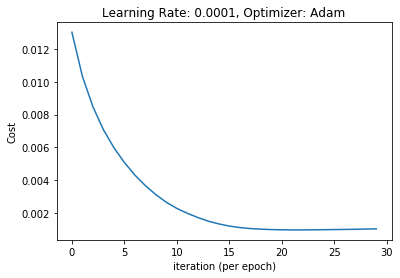

In [229]:
parameters = model(X_train, Y_train, [X_train.shape[0], 25, 10], learning_rate=0.0001, num_epochs=30)

In [230]:
print("Training Set ", end="")
p = predict(X_train, Y_train, parameters)

Training Set Accuracy: 0.08128333333333333


In [167]:
arr, arr_cache = dict_to_array(parameters, ("W", "b"))
print(arr_cache)

({'W': array([ 1.28315530e+000,  3.33570519e-001,  8.81038116e-318, ...,
       -5.66457188e-002,  1.89680457e+000, -3.57932416e-002]), 'b': array([ 1.47445329, -1.61740549,  1.80350657,  1.7038613 ,  1.76384959,
       -1.67560241, -1.70483768, -0.12867636,  1.74997135,  1.713352  ,
        1.73989194,  1.7235258 ,  1.82227816,  1.81135984,  1.66672606,
        1.8754221 ,  1.87888373,  1.85221974,  1.87967545,  1.88017572,
       -1.6961332 ,  1.87832627,  1.87593979,  1.87542893,  1.87526757])}, {'W1': 11760, 'b1': 15, 'W2': 150, 'b2': 10})


In [101]:
params = vector_to_dict(arr_cache, [X_train.shape[0], 15, 10])
print(params)

11760 15
150 10
{'W1': array([[ 2.42514736e-316, -3.53001357e-317, -1.05593676e-316, ...,
        -7.89838144e-317,  1.95739817e-317,  8.96824601e-317],
       [-7.01372775e-317, -1.05499547e-316, -4.73887437e-002, ...,
         2.78815063e-316, -6.86830496e-317,  5.65714277e-099],
       [-2.31920743e-316,  1.25319702e-317, -1.42625275e-316, ...,
        -2.38026026e-316,  4.64463258e-317, -3.18559596e-317],
       ...,
       [-4.07559990e-179,  9.56902390e-317, -1.04371027e-316, ...,
         1.04812227e-316,  9.84372391e-317,  1.35439075e-316],
       [-1.01162208e-192, -8.53042282e-317, -5.24071290e-317, ...,
         4.68354321e-317,  8.52878746e-317,  2.63509311e-006],
       [ 6.89516336e-317, -7.00167847e-317, -7.03220432e-317, ...,
         7.18534738e-317, -1.13313561e-317, -2.03629324e-316]]), 'b1': array([[-0.2690973 ],
       [-0.36000554],
       [ 0.88249666],
       [ 0.88668348],
       [ 0.24300329],
       [ 0.88285005],
       [-0.01085237],
       [ 0.88674715],
 

Test Set Accuracy: 0.0978
[]


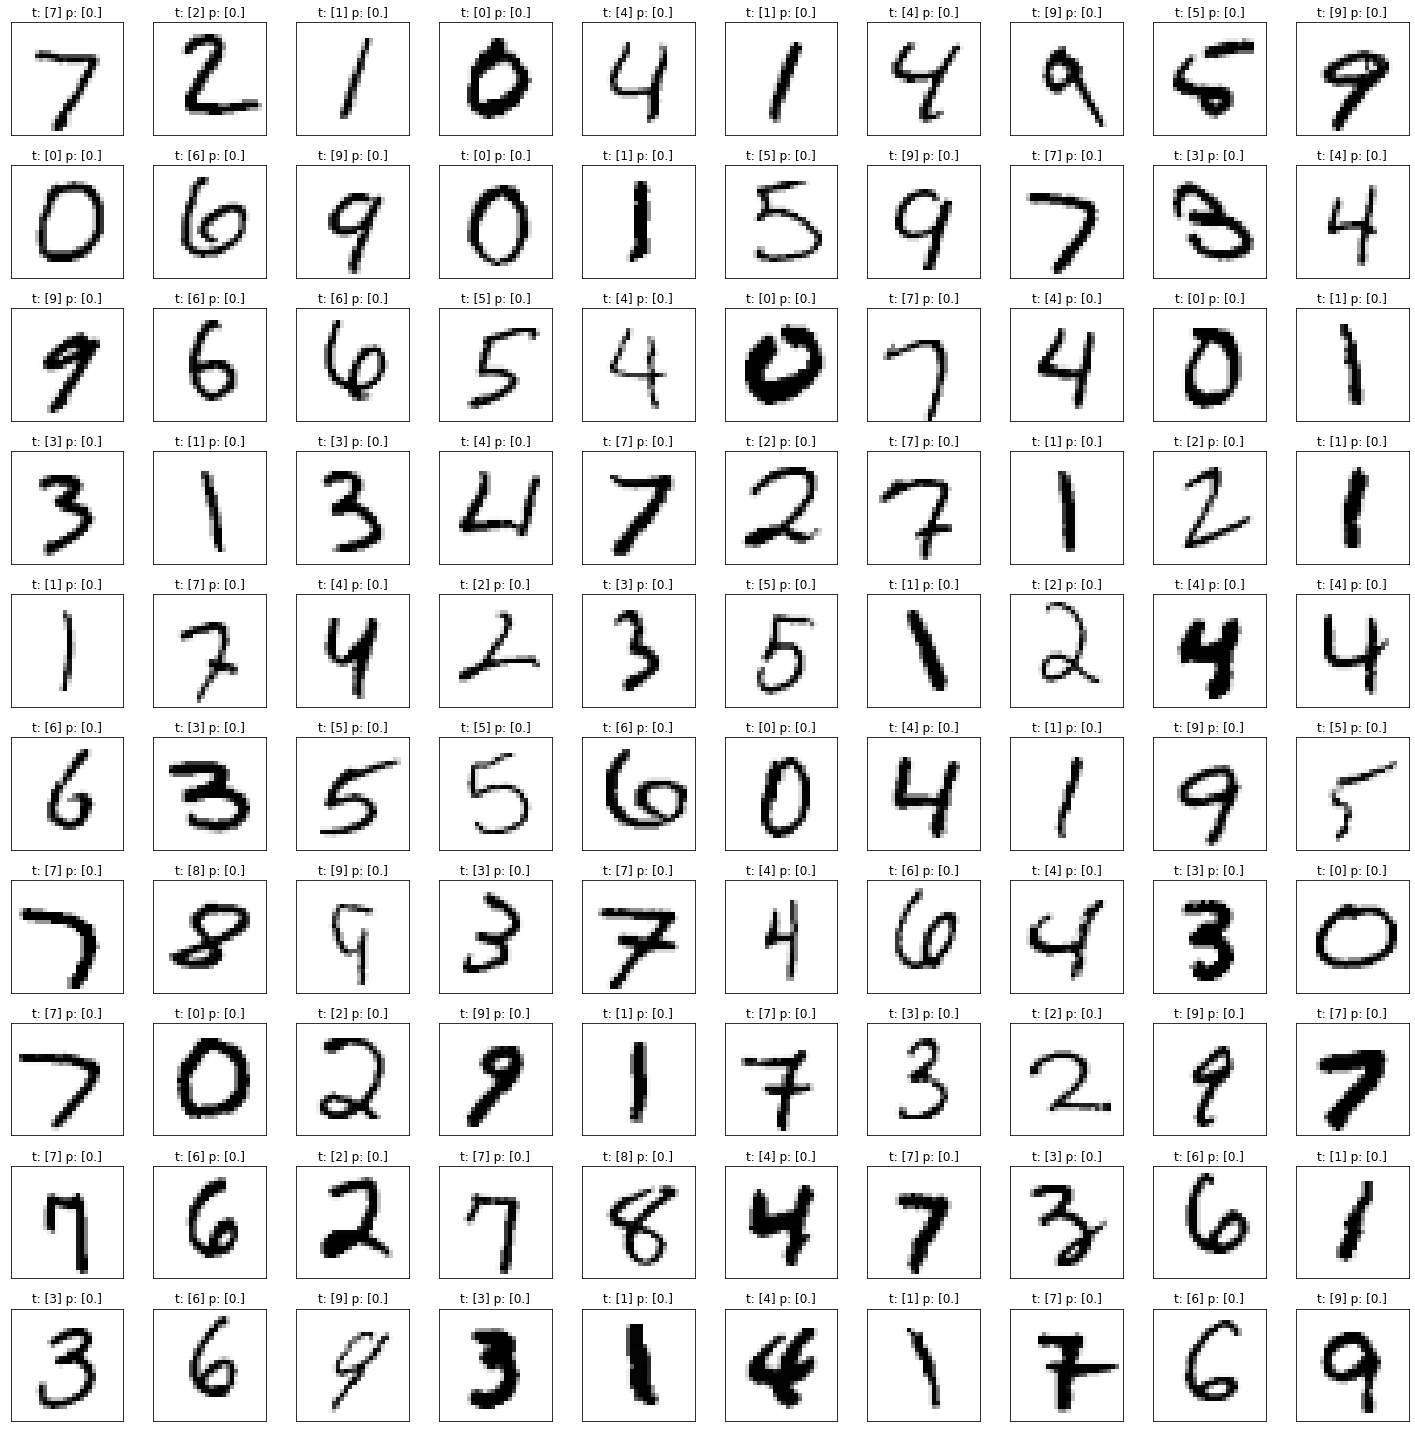

In [228]:
print("Test Set ", end="")
preds_test = predict(X_test, Y_test, parameters)
test_set(X_test, Y_test, p)